In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
from sea_breeze.load_model_data import *
from sea_breeze.sea_breeze_funcs import single_col_circulation, load_angle_ds, kinematic_frontogenesis, vert_mean_wind, weighted_vert_mean_wind
import datetime as dt
import pandas as pd
import tqdm
import hvplot.xarray
import metpy.calc as mpcalc
import metpy.units as units

In [2]:
from climtas.nci import GadiClient
client = GadiClient()
client

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.07/lib/python3.10/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 35381 instead
  warnings.warn(


<Client: 'tcp://127.0.0.1:43335' processes=4 threads=4, memory=18.00 GiB>

In [3]:
# lat_slice=slice(-45,-8)
# lon_slice=slice(110,155)
lat_slice=slice(-45,-30)
lon_slice=slice(140,155)
t1="2024-01-29 06:00"
t2="2024-01-29 06:00"

In [4]:
#Load BARRA surface variables for frontogenesis function (surface temp, moisture, wind)
domain_id = "AUS-11"
freq = "1hr"
vert_coord = "pressure"
barra_var_names = ["uas","vas","huss","ps","tas","ua925","zg925","va925"]
barrar_vars = load_barra_variable(barra_var_names, t1, t2, domain_id, freq, lat_slice, lon_slice, chunks={"lat":-1,"lon":-1})
barrar_vars = barra_sfc_moisture(barrar_vars)
barrar_angles = load_angle_ds("/g/data/gb02/ab4502/coastline_data/barra_r_angles_v2.nc",lat_slice,lon_slice)

#Load pressure level wind data for calculating mean wind
# unames = ["ua1000","ua925","ua850","ua700","ua600","ua500"]
# vnames = ["va1000","va925","va850","va700","va600","va500"]
# barrar_wind_ds = load_barra_wind_data(unames, vnames, t1, t2, domain_id, freq, lat_slice, lon_slice, vert_coord)

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.07/lib/python3.10/site-packages/xarray/backends/plugins.py:110: RuntimeWarning: Engine 'cfradial1' loading failed:
cannot import name 'HybridMappingProxy' from 'xarray.core.utils' (/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.07/lib/python3.10/site-packages/xarray/core/utils.py)
  external_backend_entrypoints = backends_dict_from_pkg(entrypoints_unique)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.07/lib/python3.10/site-packages/xarray/backends/plugins.py:110: RuntimeWarning: Engine 'datamet' loading failed:
cannot import name 'HybridMappingProxy' from 'xarray.core.utils' (/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.07/lib/python3.10/site-packages/xarray/core/utils.py)
  external_backend_entrypoints = backends_dict_from_pkg(entrypoints_unique)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.07/lib/python3.10/site-packages/xarray/backends/plugins.py:110: RuntimeWarning: Engine 'furuno' loading failed:
can

In [109]:
u = barrar_vars["uas"]["uas"]
v = barrar_vars["vas"]["vas"]
q = barrar_vars["huss"]["huss"]
angle_ds = barrar_angles

#Define angle of coastline orientation from N
theta=angle_ds.angle_interp 

#Rotate angle to be perpendicular to theta, from E (i.e. mathamatical angle definition)
rotated_angle=(((theta)%360-90)%360) + 90   

#Define normal angle vectors, pointing onshore
cx, cy = [-np.cos(np.deg2rad(rotated_angle)), np.sin(np.deg2rad(rotated_angle))]

#Define normal angle vectors, pointing alongshore
ax, ay = [-np.cos(np.deg2rad(rotated_angle - 90)), np.sin(np.deg2rad(rotated_angle - 90))]    

#Calculate the wind component perpendicular and parallel to the coast by using the normal unit vectors
#vprime = ((u*cx) + (v*cy))
#uprime = ((u*ax) + (v*ay))
uprime = u
vprime = v

#Calculate the gradients of moisture, and (rotated) winds in x/y coordinates
dq_dx, dq_dy = mpcalc.geospatial_gradient((q * units.units("g/g")).metpy.convert_units("g/kg"), x_dim=q.get_axis_num("lon"), y_dim=q.get_axis_num("lat"))
dvprime_dx, dvprime_dy = mpcalc.geospatial_gradient(vprime*units.units("m/s"), x_dim=vprime.get_axis_num("lon"), y_dim=vprime.get_axis_num("lat"))
duprime_dx, duprime_dy = mpcalc.geospatial_gradient(uprime*units.units("m/s"), x_dim=uprime.get_axis_num("lon"), y_dim=uprime.get_axis_num("lat"))

#Rotate gradients to cross shore (c) and along shore (a)
dq_dc = (dq_dx*cx.values) + (dq_dy*cy.values)    
dvprime_dc = (dvprime_dx*cx.values) + (dvprime_dy*cy.values)
duprime_dc = (duprime_dx*cx.values) + (duprime_dy*cy.values)

dq_da = (dq_dx*ax.values) + (dq_dy*ay.values)    

#Calculate the gradient in moisture convergence, convert to a Dataarray, and return
#dq_conv = (dq_dc * dvprime_dc)
#confluence = dq_dc * dvprime_dc
#shearing = dq_da * duprime_dc
confluence = dq_dc * dvprime_dc
shearing = dq_da * duprime_dc


/jobfs/127928880.gadi-pbs/ipykernel_1269891/3504226164.py:23: UserWarning: More than one vertical coordinate present for variable  "huss".
  dq_dx, dq_dy = mpcalc.geospatial_gradient((q * units.units("g/g")).metpy.convert_units("g/kg"), x_dim=q.get_axis_num("lon"), y_dim=q.get_axis_num("lat"))


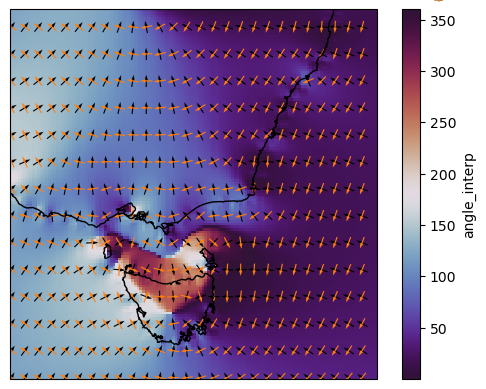

In [110]:
axis=plt.axes(projection=ccrs.PlateCarree())
theta.plot(cmap="twilight_shifted")
xr.Dataset({"cx":cx,"cy":cy}).isel(lon=slice(0,-1,5),lat=slice(0,-1,10)).plot.quiver(x="lon",y="lat",u="cx",v="cy",scale=30)
xr.Dataset({"ax":ax,"ay":ay}).isel(lon=slice(0,-1,5),lat=slice(0,-1,10)).plot.quiver(x="lon",y="lat",u="ax",v="ay",scale=30,color="tab:orange")
axis.coastlines()

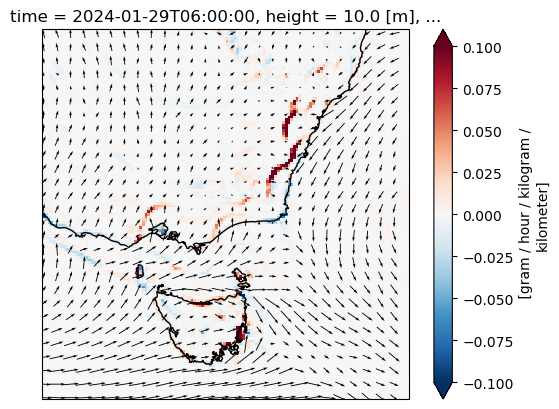

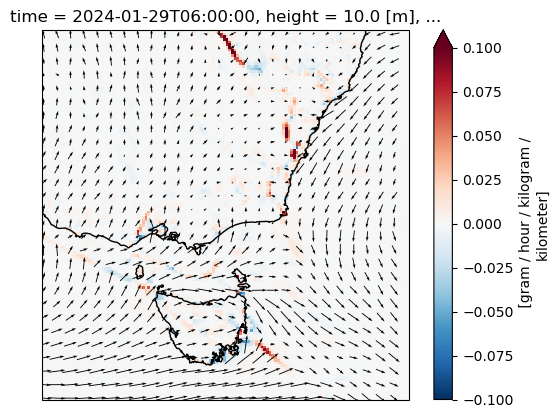

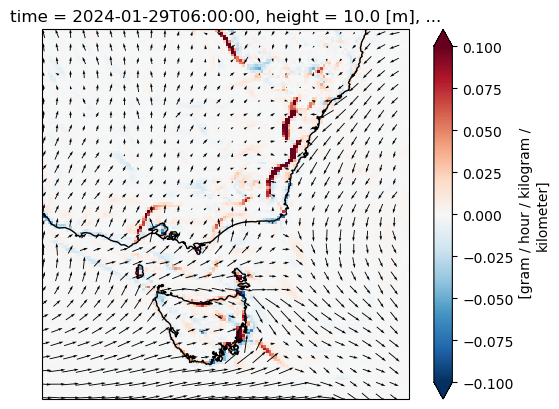

In [111]:
axis=plt.axes(projection=ccrs.PlateCarree())
xr.DataArray(confluence.to("g/kg/km/hr"),coords={"time":q.time,"lat":q.lat,"lon":q.lon}).plot(vmin=-0.1,vmax=0.1,cmap="RdBu_r")
xr.Dataset({"u":barrar_vars["uas"]["uas"],"v":barrar_vars["vas"]["vas"]}).isel(lat=slice(0,-1,5),lon=slice(0,-1,5)).sel(time="2024-01-29 06:00").plot.quiver(x="lon",y="lat",u="u",v="v",scale=250,add_guide=False)
axis.coastlines()

plt.figure()
axis=plt.axes(projection=ccrs.PlateCarree())
xr.DataArray(shearing.to("g/kg/km/hr"),coords={"time":q.time,"lat":q.lat,"lon":q.lon}).plot(vmin=-0.1,vmax=0.1,cmap="RdBu_r")
xr.Dataset({"u":barrar_vars["uas"]["uas"],"v":barrar_vars["vas"]["vas"]}).isel(lat=slice(0,-1,5),lon=slice(0,-1,5)).sel(time="2024-01-29 06:00").plot.quiver(x="lon",y="lat",u="u",v="v",scale=250,add_guide=False)
axis.coastlines()

plt.figure()
axis=plt.axes(projection=ccrs.PlateCarree())
xr.DataArray((shearing+confluence).to("g/kg/km/hr"),coords={"time":q.time,"lat":q.lat,"lon":q.lon}).plot(vmin=-0.1,vmax=0.1,cmap="RdBu_r")
xr.Dataset({"u":barrar_vars["uas"]["uas"],"v":barrar_vars["vas"]["vas"]}).isel(lat=slice(0,-1,5),lon=slice(0,-1,5)).sel(time="2024-01-29 06:00").plot.quiver(x="lon",y="lat",u="u",v="v",scale=250,add_guide=False)
axis.coastlines()

In [82]:
#Calculate frontogenesis from BARRA-R
barrar_Fq = kinematic_frontogenesis(
    barrar_vars["q"],
    barrar_vars["uas"]["uas"],
    barrar_vars["vas"]["vas"],
    subtract_mean=False,
    weighted_mean=True,
    wind_ds=None,
    mean_heights=[1000,500],
    vert_coord="pressure").persist()

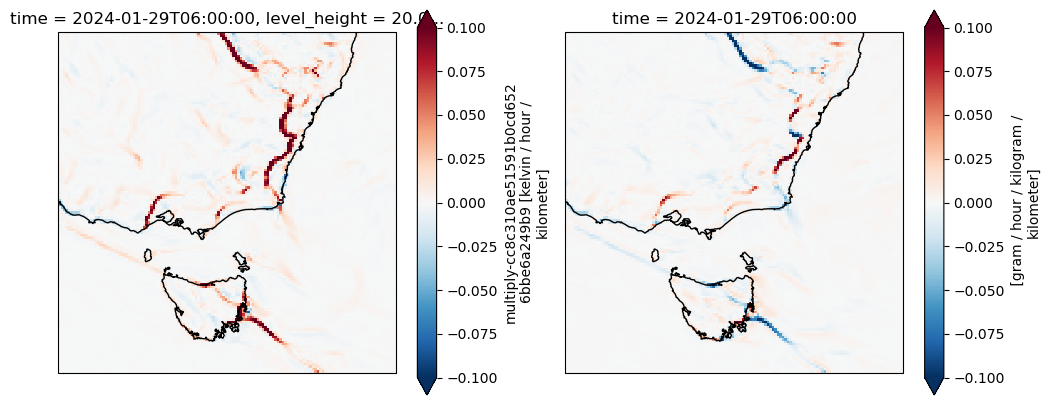

In [108]:
plt.figure(figsize=[12,5])

ax=plt.subplot(1,2,1,projection=ccrs.PlateCarree())
(barrar_Fq / 1.08e9 * 1000).metpy.convert_units("K/km/hr").plot(vmin=-0.1,vmax=0.1,cmap="RdBu_r")
ax.coastlines()

ax=plt.subplot(1,2,2,projection=ccrs.PlateCarree())
xr.DataArray((shearing+confluence).to("g/kg/km/hr"),coords={"time":q.time,"lat":q.lat,"lon":q.lon}).plot(vmin=-0.1,vmax=0.1,cmap="RdBu_r")
ax.coastlines()

In [61]:
dq_conv = moisture_gradient_convergence(barrar_vars["huss"]["huss"],barrar_vars["uas"]["uas"],barrar_vars["vas"]["vas"],barrar_angles).persist()

/jobfs/127789505.gadi-pbs/ipykernel_473983/2041305022.py:43: UserWarning: More than one vertical coordinate present for variable  "huss".
  dq_dx, dq_dy = mpcalc.geospatial_gradient((q * units.units("g/g")).metpy.convert_units("g/kg"), x_dim=q.get_axis_num("lon"), y_dim=q.get_axis_num("lat"))


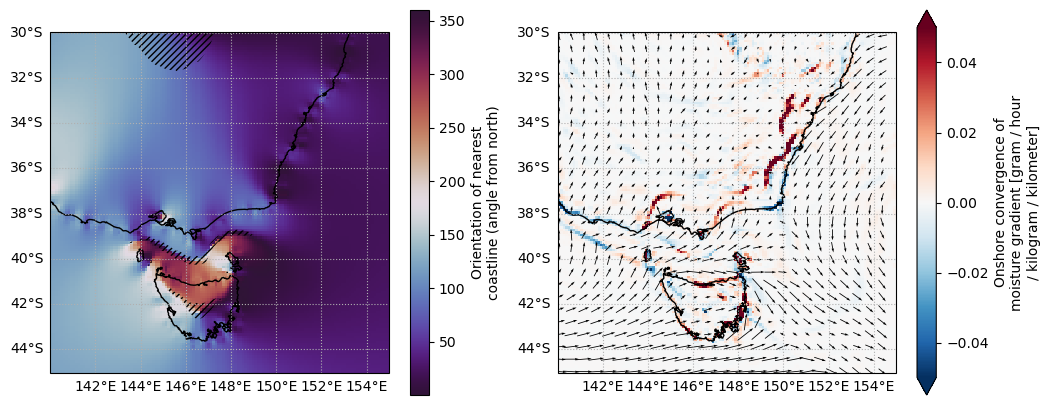

In [63]:
plt.figure(figsize=[12,5])

ax=plt.subplot(1,2,1,projection=ccrs.PlateCarree())
barrar_angles.angle_interp.rename("Orientation of nearest coastline (angle from north)").plot(cmap="twilight_shifted")
xr.plot.contourf(barrar_angles.variance,levels=[0.,0.6],hatches=["","/////"],colors="none",add_colorbar=False)
ax.coastlines()
ax.gridlines(draw_labels=["left","bottom"],ls=":")

ax=plt.subplot(1,2,2,projection=ccrs.PlateCarree())
dq_conv.rename("Onshore convergence of moisture gradient").sel(time="2024-01-29 06:00").plot(vmin=-0.05,vmax=0.05,cmap="RdBu_r")
xr.Dataset({"u":barrar_vars["uas"]["uas"],"v":barrar_vars["vas"]["vas"]}).isel(lat=slice(0,-1,5),lon=slice(0,-1,5)).sel(time="2024-01-29 06:00").plot.quiver(x="lon",y="lat",u="u",v="v",scale=250,add_guide=False)
ax.coastlines()
plt.title("")
ax.gridlines(draw_labels=["left","bottom"],ls=":")

#plt.savefig("/g/data/gb02/ab4502/figs/example_plot.jpeg",dpi=1000)

In [113]:
barrar_vars["zg925"]

<xarray.Dataset> Size: 1MB
Dimensions:   (time: 7, lat: 137, lon: 136)
Coordinates:
  * time      (time) datetime64[ns] 56B 2024-01-29 ... 2024-01-29T06:00:00
    pressure  float64 8B ...
  * lon       (lon) float64 1kB 140.1 140.2 140.3 140.4 ... 154.7 154.8 154.9
  * lat       (lat) float64 1kB -44.99 -44.88 -44.77 ... -30.25 -30.14 -30.03
    crs       int32 4B ...
Data variables:
    zg925     (time, lat, lon) float64 1MB dask.array<chunksize=(7, 137, 136), meta=np.ndarray>
Attributes: (12/79)
    axiom_version:                           0.1.0
    axiom_schemas_version:                   0.1.0
    axiom_schema:                            cordex-1H.json
    productive_version:                      aa42d45
    variable_version:                        v20240516
    Conventions:                             CF-1.10, ACDD-1.3
    ...                                      ...
    intake_esm_attrs:version:                v20240809
    intake_esm_attrs:start_time:             202401.0
    intake_esm_attrs:end_time:               202401.0
    intake_esm_attrs:time_range:             202401-202401
    intake_esm_attrs:_data_format_:          netcdf
    intake_esm_dataset_key:                  f.output.reanalysis.AUS-11.BOM.E...

In [129]:
xx,yy=np.meshgrid(barrar_vars["zg925"]["zg925"].lon,barrar_vars["zg925"]["zg925"].lat)
dx,dy=mpcalc.lat_lon_grid_deltas(xx,yy,x_dim=1,y_dim=0)

In [143]:
u_ag.shape

(137, 136)

In [156]:
u_ag, v_ag = mpcalc.ageostrophic_wind(barrar_vars["zg925"]["zg925"],
                        barrar_vars["ua925"]["ua925"] * units.units("m/s"),
                        barrar_vars["va925"]["va925"] * units.units("m/s"),
                        x_dim=barrar_vars["vas"]["vas"].get_axis_num("lon"),
                        y_dim=barrar_vars["vas"]["vas"].get_axis_num("lat"))

u_g, v_g = mpcalc.geostrophic_wind(barrar_vars["zg925"]["zg925"],
                        x_dim=barrar_vars["vas"]["vas"].get_axis_num("lon"),
                        y_dim=barrar_vars["vas"]["vas"].get_axis_num("lat"))

In [166]:
tot_def = mpcalc.total_deformation(
    barrar_vars["uas"]["uas"], 
    barrar_vars["vas"]["vas"], 
    x_dim=barrar_vars["vas"]["vas"].get_axis_num("lon"), 
    y_dim=barrar_vars["vas"]["vas"].get_axis_num("lat"))

div = mpcalc.divergence(
    barrar_vars["uas"]["uas"], 
    barrar_vars["vas"]["vas"], 
    x_dim=barrar_vars["vas"]["vas"].get_axis_num("lon"), 
    y_dim=barrar_vars["vas"]["vas"].get_axis_num("lat"))

Text(0.5, 1.0, 'Ageostropic 925 hPa wind')

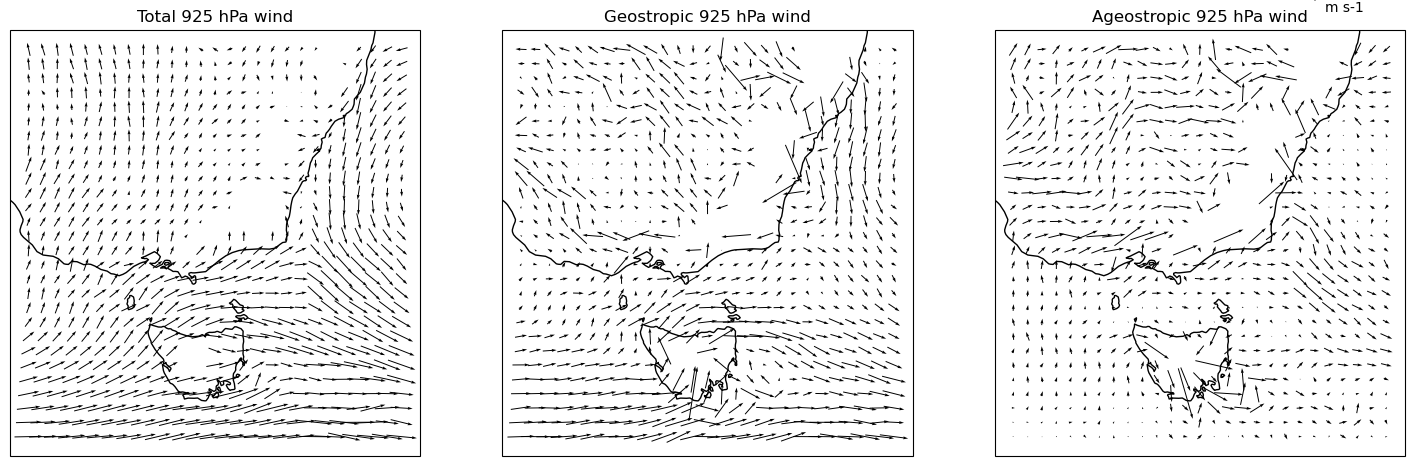

In [164]:
plt.figure(figsize=[18,6])
t = 6
ax=plt.subplot(1,3,1,projection=ccrs.PlateCarree())
xr.Dataset({"u":barrar_vars["ua925"]["ua925"],"v":barrar_vars["va925"]["va925"]}).isel(time=t,lat=slice(0,-1,5),lon=slice(0,-1,5)).plot.quiver(x="lon",y="lat",u="u",v="v",scale=250)
ax.coastlines()
plt.title("Total 925 hPa wind")

ax=plt.subplot(1,3,2,projection=ccrs.PlateCarree())
g = xr.Dataset({"u":(("lat","lon"),np.array(u_g[t])),
           "v":(("lat","lon"),np.array(v_g[t]))},coords={"lat":barrar_vars["uas"]["uas"].lat,"lon":barrar_vars["uas"]["uas"].lon})
g.isel(lat=slice(0,-1,5),lon=slice(0,-1,5)).plot.quiver(x="lon",y="lat",u="u",v="v",scale=250)
ax.coastlines()
plt.title("Geostropic 925 hPa wind")

ax=plt.subplot(1,3,3,projection=ccrs.PlateCarree())
ag = xr.Dataset({"u":(("lat","lon"),np.array(u_ag[t])),
           "v":(("lat","lon"),np.array(v_ag[t]))},coords={"lat":barrar_vars["uas"]["uas"].lat,"lon":barrar_vars["uas"]["uas"].lon})
ag.isel(lat=slice(0,-1,5),lon=slice(0,-1,5)).plot.quiver(x="lon",y="lat",u="u",v="v",scale=250)
ax.coastlines()
plt.title("Ageostropic 925 hPa wind")

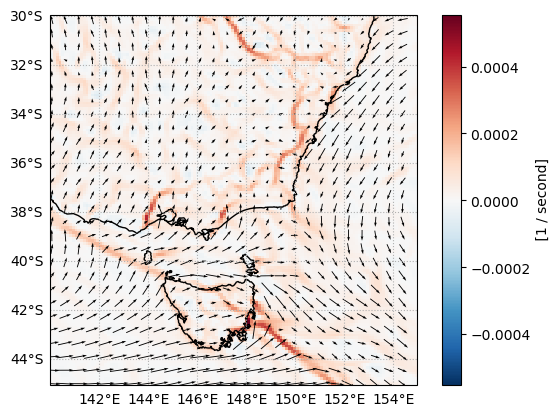

In [173]:
#ICON

ax=plt.axes(projection=ccrs.PlateCarree())
(0.5 * (tot_def - div)).sel(time="2024-01-29 06:00").plot()
xr.Dataset({"u":barrar_vars["uas"]["uas"],"v":barrar_vars["vas"]["vas"]}).isel(lat=slice(0,-1,5),lon=slice(0,-1,5)).sel(time="2024-01-29 06:00").plot.quiver(x="lon",y="lat",u="u",v="v",scale=250,add_guide=False)
ax.coastlines()
plt.title("")
ax.gridlines(draw_labels=["left","bottom"],ls=":")


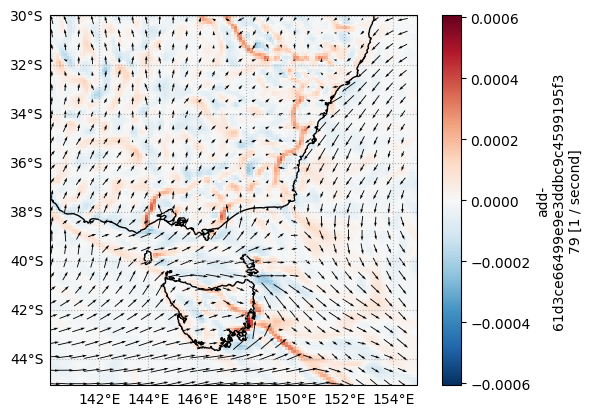

In [175]:
#ICON

ax=plt.axes(projection=ccrs.PlateCarree())
(-div).sel(time="2024-01-29 06:00").plot()
xr.Dataset({"u":barrar_vars["uas"]["uas"],"v":barrar_vars["vas"]["vas"]}).isel(lat=slice(0,-1,5),lon=slice(0,-1,5)).sel(time="2024-01-29 06:00").plot.quiver(x="lon",y="lat",u="u",v="v",scale=250,add_guide=False)
ax.coastlines()
plt.title("")
ax.gridlines(draw_labels=["left","bottom"],ls=":")


In [10]:
!rm /g/data/gb02/ab4502/figs/sea_breeze/*png
quiver_plot =  xr.Dataset({"u":barrar_vars["uas"]["uas"],"v":barrar_vars["vas"]["vas"]}).isel(lat=slice(0,-1,12),lon=slice(0,-1,12)).persist()
for t in tqdm.tqdm(dq_conv.time):
#t="2024-01-29 06:00"

    plt.figure(figsize=[16,5])
    
    ax=plt.subplot(1,3,1,projection=ccrs.PlateCarree())
    barrar_Fq.sel(time=t).plot(cmap="RdBu_r",vmin=-0.1,vmax=0.1,extend="both")
    quiver_plot.sel(time=t).plot.quiver(x="lon",y="lat",u="u",v="v",scale=250)
    ax.coastlines()
    
    ax=plt.subplot(1,3,2,projection=ccrs.PlateCarree())
    dq_conv.sel(time=t).plot(cmap="RdBu_r",vmin=-0.1,vmax=0.1,extend="both")
    quiver_plot.sel(time=t).plot.quiver(x="lon",y="lat",u="u",v="v",scale=250)
    ax.coastlines()
    
    ax=plt.subplot(1,3,3,projection=ccrs.PlateCarree())
    barrar_vars["huss"]["huss"].sel(time=t).plot(cmap="Blues",vmin=0,vmax=0.025,extend="max")
    quiver_plot.sel(time=t).plot.quiver(x="lon",y="lat",u="u",v="v",scale=250)
    ax.coastlines()
    
    plt.savefig("/g/data/gb02/ab4502/figs/sea_breeze/"+pd.to_datetime(t.values).strftime("%Y%m%d%H%M")+".png")
    plt.close()

100%|██████████| 97/97 [02:49<00:00,  1.74s/it]


In [12]:
#Calculate frontogenesis from BARRA-R
barrar_Ftheta = kinematic_frontogenesis(
    barrar_vars["thetae"] * units.units("1/K"),
    barrar_vars["uas"]["uas"],
    barrar_vars["vas"]["vas"],
    subtract_mean=False,
    weighted_mean=True,
    wind_ds=None,
    mean_heights=[1000,500],
    vert_coord="pressure").persist()

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.07/lib/python3.10/site-packages/distributed/client.py:3361: UserWarning: Sending large graph of size 1.08 GiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


In [17]:
dtheta_conv = moisture_gradient_convergence(barrar_vars["thetae"] * units.units("1/K"),
                                            barrar_vars["uas"]["uas"]
                                            ,barrar_vars["vas"]["vas"],barrar_angles).persist()

In [30]:
!rm /g/data/gb02/ab4502/figs/sea_breeze/*png
quiver_plot =  xr.Dataset({"u":barrar_vars["uas"]["uas"],"v":barrar_vars["vas"]["vas"]}).isel(lat=slice(0,-1,12),lon=slice(0,-1,12)).persist()
for t in tqdm.tqdm(dq_conv.time):
#t="2024-01-29 06:00"

    plt.figure(figsize=[16,5])
    
    ax=plt.subplot(1,3,1,projection=ccrs.PlateCarree())
    barrar_Ftheta.sel(time=t).plot(cmap="RdBu_r",vmin=-100,vmax=100,extend="both")
    quiver_plot.sel(time=t).plot.quiver(x="lon",y="lat",u="u",v="v",scale=250)
    ax.coastlines()
    
    ax=plt.subplot(1,3,2,projection=ccrs.PlateCarree())
    dtheta_conv.sel(time=t).plot(cmap="RdBu_r",vmin=-100,vmax=100,extend="both")
    quiver_plot.sel(time=t).plot.quiver(x="lon",y="lat",u="u",v="v",scale=250)
    ax.coastlines()
    
    ax=plt.subplot(1,3,3,projection=ccrs.PlateCarree())
    barrar_vars["thetae"].sel(time=t).plot(cmap="Blues",vmin=310,vmax=380,extend="max")
    quiver_plot.sel(time=t).plot.quiver(x="lon",y="lat",u="u",v="v",scale=250)
    ax.coastlines()
    
    plt.savefig("/g/data/gb02/ab4502/figs/sea_breeze/"+pd.to_datetime(t.values).strftime("%Y%m%d%H%M")+".png")
    plt.close()

100%|██████████| 97/97 [06:40<00:00,  4.13s/it]


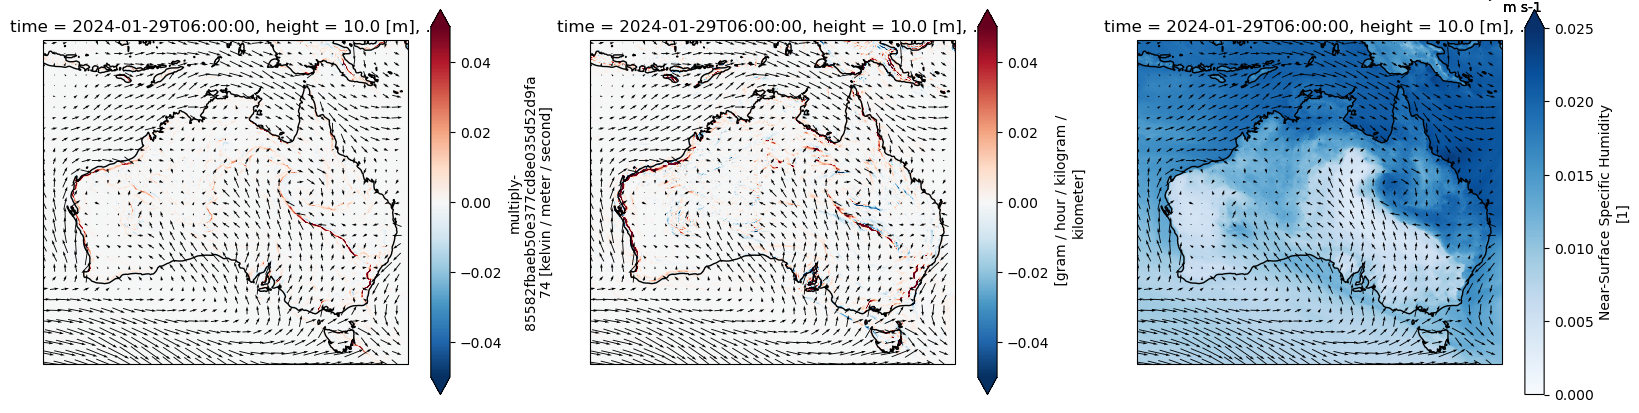

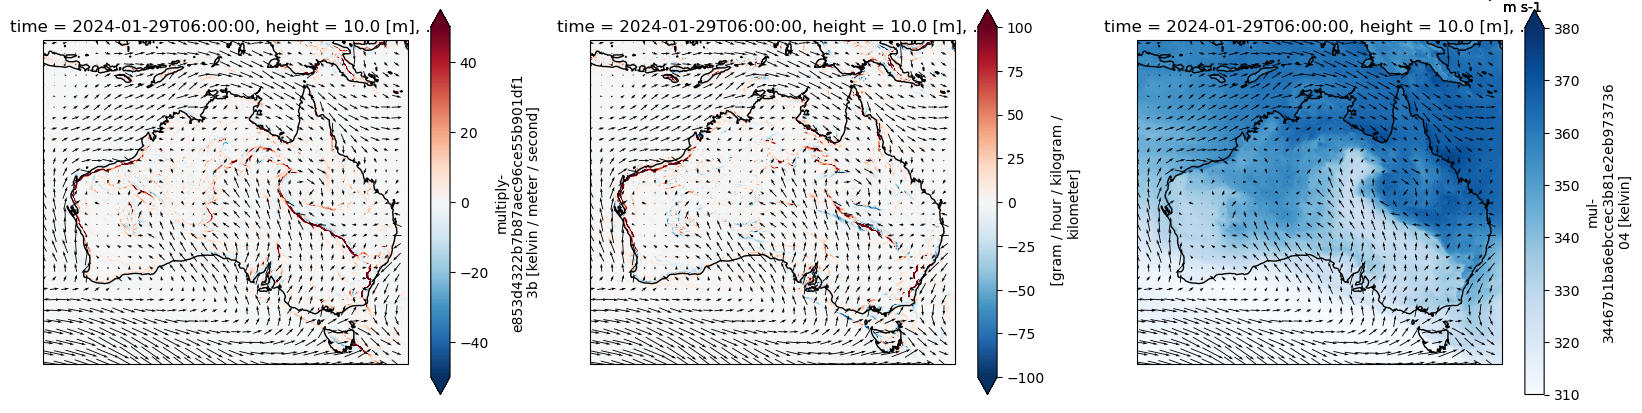

In [65]:
t="2024-01-29 06:00"

plt.figure(figsize=[20,5])

ax=plt.subplot(1,3,1,projection=ccrs.PlateCarree())
barrar_Fq.sel(time=t).plot(cmap="RdBu_r",vmin=-0.05,vmax=.05,extend="both")
quiver_plot.sel(time=t).plot.quiver(x="lon",y="lat",u="u",v="v",scale=250)
ax.coastlines()

ax=plt.subplot(1,3,2,projection=ccrs.PlateCarree())
dq_conv.sel(time=t).plot(cmap="RdBu_r",vmin=-0.05,vmax=.05,extend="both")
quiver_plot.sel(time=t).plot.quiver(x="lon",y="lat",u="u",v="v",scale=250)
ax.coastlines()

ax=plt.subplot(1,3,3,projection=ccrs.PlateCarree())
barrar_vars["huss"]["huss"].sel(time=t).plot(cmap="Blues",vmin=0,vmax=0.025,extend="max")
quiver_plot.sel(time=t).plot.quiver(x="lon",y="lat",u="u",v="v",scale=250)
ax.coastlines()


plt.figure(figsize=[20,5])

ax=plt.subplot(1,3,1,projection=ccrs.PlateCarree())
barrar_Ftheta.sel(time=t).plot(cmap="RdBu_r",vmin=-50,vmax=50,extend="both")
quiver_plot.sel(time=t).plot.quiver(x="lon",y="lat",u="u",v="v",scale=250)
ax.coastlines()

ax=plt.subplot(1,3,2,projection=ccrs.PlateCarree())
dtheta_conv.sel(time=t).plot(cmap="RdBu_r",vmin=-100,vmax=100,extend="both")
quiver_plot.sel(time=t).plot.quiver(x="lon",y="lat",u="u",v="v",scale=250)
ax.coastlines()

ax=plt.subplot(1,3,3,projection=ccrs.PlateCarree())
barrar_vars["thetae"].sel(time=t).plot(cmap="Blues",vmin=310,vmax=380,extend="max")
quiver_plot.sel(time=t).plot.quiver(x="lon",y="lat",u="u",v="v",scale=250)
ax.coastlines()

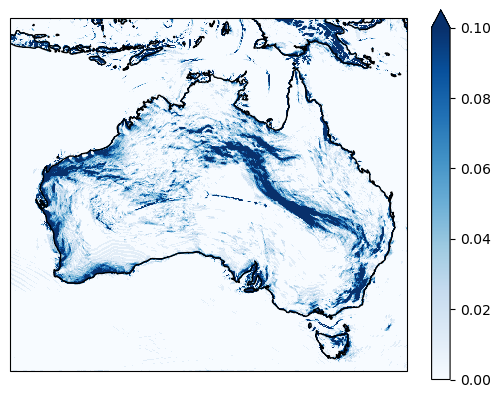

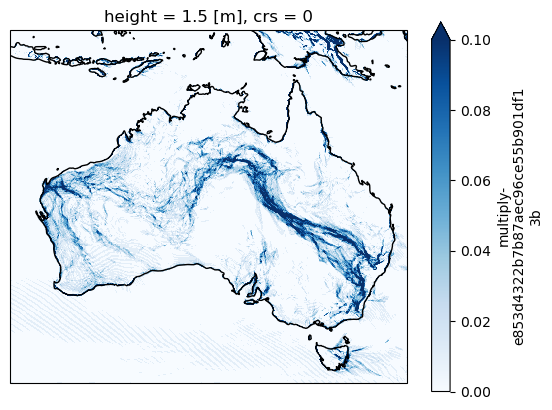

In [66]:
ax=plt.axes(projection=ccrs.PlateCarree())
(dq_conv >= 0.01*units.units("g/hr/kg/km")).mean("time").plot(cmap="Blues",vmax=0.1)
ax.coastlines()

plt.figure()
ax=plt.axes(projection=ccrs.PlateCarree())
(barrar_Ftheta >= 25*units.units("K/m/s")).mean("time").plot(cmap="Blues",vmax=0.1)
ax.coastlines()

In [5]:
#Load boundary layer height for SBI, as well as surface wind, temp and moisture, and pressure level winds, for frontogenesis function
era5_var_names = ["blh","2d","sp","2t","10u","10v","u","v"]
era5_vars = load_era5_variable(era5_var_names,t1,t2,lon_slice,lat_slice)
era5_pl_wind = xr.Dataset(
    {"u":era5_vars["u"]["u"],
     "v":era5_vars["v"]["v"]})

In [6]:
#Calculate surface mixing ratio and theta-e for frontogenesis function
era5_vars = era5_sfc_moisture(era5_vars)

In [7]:
#Load coastline angles for SBI
era5_angles = load_angle_ds("/g/data/gb02/ab4502/coastline_data/era5_angles_v2.nc",lat_slice,lon_slice)

In [11]:
#Calculate frontogenesis from ERA5
era5_Fq = kinematic_frontogenesis(
    era5_vars["q"],
    era5_vars["10u"]["u10"],
    era5_vars["10v"]["v10"],
    subtract_mean=False,
    weighted_mean=True,
    wind_ds=era5_pl_wind,
    mean_heights=[500,1000],
    vert_coord="level").persist()

In [12]:
#Calculate frontogenesis from ERA5
era5_Fq = kinematic_frontogenesis(
    era5_vars["q"],
    era5_vars["10u"]["u10"],
    era5_vars["10v"]["v10"],
    subtract_mean=True,
    weighted_mean=True,
    wind_ds=era5_pl_wind,
    mean_heights=[500,1000],
    vert_coord="level").persist()

/jobfs/127644804.gadi-pbs/ipykernel_2233160/1799196164.py:43: UserWarning: More than one vertical coordinate present for variable  "huss".
  dq_dx, dq_dy = mpcalc.geospatial_gradient((q * units.units("g/g")).metpy.convert_units("g/kg"), x_dim=q.get_axis_num("lon"), y_dim=q.get_axis_num("lat"))


100%|██████████| 241/241 [09:20<00:00,  2.33s/it]


In [ ]:
#Load BARRA surface variables for frontogenesis function (surface temp, moisture, wind)
domain_id = "AUST-04"
barrac_vars = load_barra_variable(barra_var_names, t1, t2, domain_id, freq, lat_slice, lon_slice)
barrac_vars = barra_sfc_moisture(barrac_vars)

#Load pressure level wind data for calculating mean wind
unames = ["ua1000","ua925","ua850","ua700","ua600","ua500"]
vnames = ["va1000","va925","va850","va700","va600","va500"]
barrac_wind_ds = load_barra_wind_data(unames, vnames, t1, t2, domain_id, freq, lat_slice, lon_slice, vert_coord)

/jobfs/127644804.gadi-pbs/ipykernel_2232001/4042860298.py:43: UserWarning: More than one vertical coordinate present for variable  "huss".
  dq_dx, dq_dy = mpcalc.geospatial_gradient((q * units.units("g/g")).metpy.convert_units("g/kg"), x_dim=q.get_axis_num("lon"), y_dim=q.get_axis_num("lat"))


In [ ]:
#Calculate frontogenesis from BARRA-R
barrac_Fq = kinematic_frontogenesis(
    barrac_vars["q"],
    barrac_vars["uas"]["uas"],
    barrac_vars["vas"]["vas"],
    subtract_mean=True,
    weighted_mean=True,
    wind_ds=barrac_wind_ds,
    mean_heights=[1000,500],
    vert_coord="pressure")

/home/548/ab4502/working/sea_breeze/sea_breeze_funcs.py:183: UserWarning: More than one vertical coordinate present for variable  "truediv-7dfdcb2935601178594a26ddab8793c6".
  Fq = mpcalc.frontogenesis(q*units.units("K"),
/home/548/ab4502/working/sea_breeze/sea_breeze_funcs.py:183: UserWarning: More than one vertical coordinate present for variable  "truediv-595abb75cdfca1abe7e8c304d89fe244".
  Fq = mpcalc.frontogenesis(q*units.units("K"),


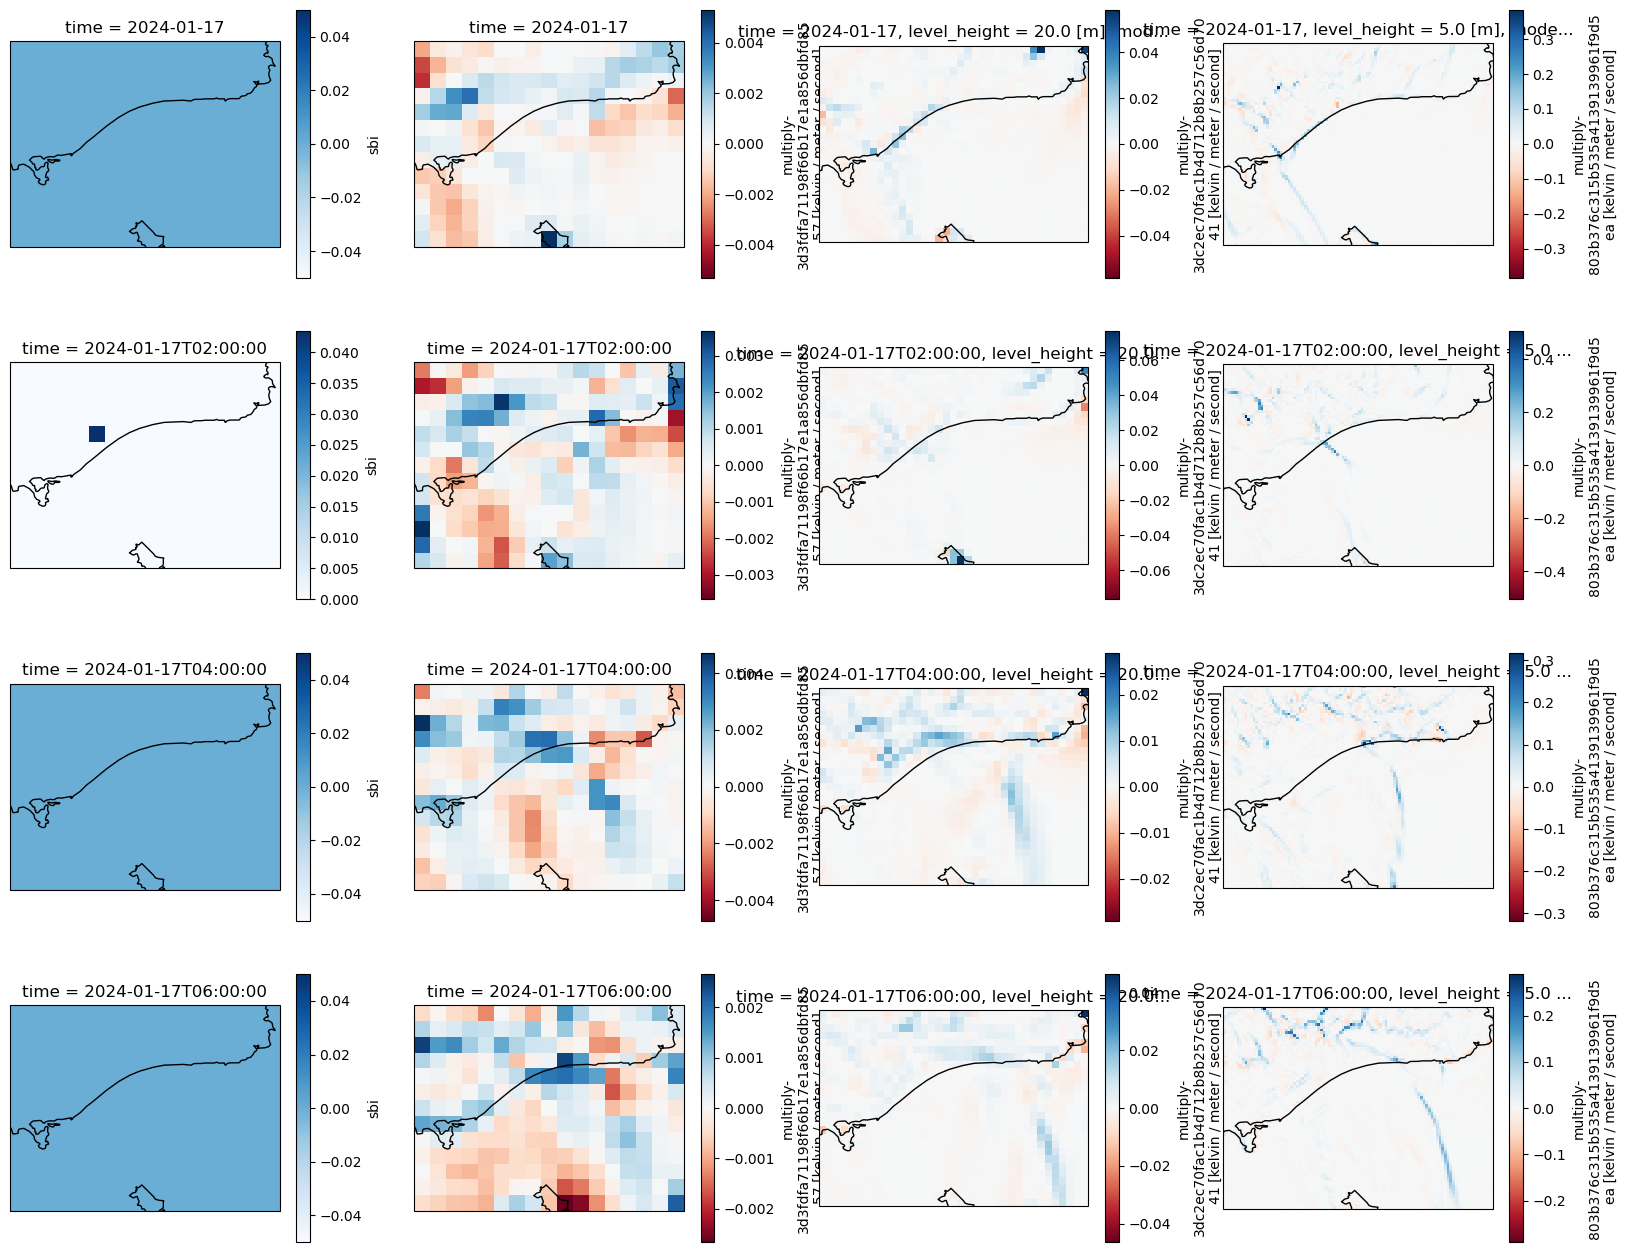

In [6]:
t1="2024-01-17 00:00"
t2="2024-01-17 02:00"
t3="2024-01-17 04:00"
t4="2024-01-17 06:00"

plt.figure(figsize=[20,16])
ax=plt.subplot(4,4,1,projection=ccrs.PlateCarree())
sbi_ds.sel(time=t1).sbi.plot(cmap="Blues")
ax.coastlines()

ax=plt.subplot(4,4,5,projection=ccrs.PlateCarree())
sbi_ds.sel(time=t2).sbi.plot(cmap="Blues")
ax.coastlines()

ax=plt.subplot(4,4,9,projection=ccrs.PlateCarree())
sbi_ds.sel(time=t3).sbi.plot(cmap="Blues")
ax.coastlines()

ax=plt.subplot(4,4,13,projection=ccrs.PlateCarree())
sbi_ds.sel(time=t4).sbi.plot(cmap="Blues")
ax.coastlines()

ax=plt.subplot(4,4,2,projection=ccrs.PlateCarree())
era5_Fq.sel(time=t1).plot(cmap="RdBu")
ax.coastlines()

ax=plt.subplot(4,4,6,projection=ccrs.PlateCarree())
era5_Fq.sel(time=t2).plot(cmap="RdBu")
ax.coastlines()

ax=plt.subplot(4,4,10,projection=ccrs.PlateCarree())
era5_Fq.sel(time=t3).plot(cmap="RdBu")
ax.coastlines()

ax=plt.subplot(4,4,14,projection=ccrs.PlateCarree())
era5_Fq.sel(time=t4).plot(cmap="RdBu")
ax.coastlines()

ax=plt.subplot(4,4,3,projection=ccrs.PlateCarree())
barrar_Fq.sel(time=t1).plot(cmap="RdBu")
ax.coastlines()

ax=plt.subplot(4,4,7,projection=ccrs.PlateCarree())
barrar_Fq.sel(time=t2).plot(cmap="RdBu")
ax.coastlines()

ax=plt.subplot(4,4,11,projection=ccrs.PlateCarree())
barrar_Fq.sel(time=t3).plot(cmap="RdBu")
ax.coastlines()

ax=plt.subplot(4,4,15,projection=ccrs.PlateCarree())
barrar_Fq.sel(time=t4).plot(cmap="RdBu")
ax.coastlines()

ax=plt.subplot(4,4,4,projection=ccrs.PlateCarree())
barrac_Fq.sel(time=t1).plot(cmap="RdBu")
ax.coastlines()

ax=plt.subplot(4,4,8,projection=ccrs.PlateCarree())
barrac_Fq.sel(time=t2).plot(cmap="RdBu")
ax.coastlines()

ax=plt.subplot(4,4,12,projection=ccrs.PlateCarree())
barrac_Fq.sel(time=t3).plot(cmap="RdBu")
ax.coastlines()

ax=plt.subplot(4,4,16,projection=ccrs.PlateCarree())
barrac_Fq.sel(time=t4).plot(cmap="RdBu")
ax.coastlines()

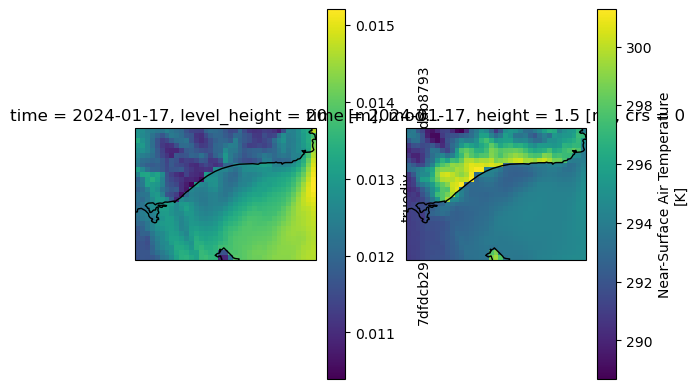

In [12]:
ax=plt.subplot(1,2,1,projection=ccrs.PlateCarree())
barrar_vars["q"].isel(time=0).plot()
ax.coastlines()

ax=plt.subplot(1,2,2,projection=ccrs.PlateCarree())
barrar_vars["tas"]["tas"].isel(time=0).plot()
ax.coastlines()

In [10]:
# !rm /g/data/gb02/ab4502/figs/sea_breeze/*png
# quiver_plot =  era5_wind[["u","v"]].sel(height=0).persist()
# for t in tqdm.tqdm(sbi.time):
#     plt.figure()
#     ax=plt.axes(projection=ccrs.PlateCarree())
#     sbi.sel(time=t).plot(cmap="Blues",vmin=0,vmax=1)
#     quiver_plot.sel(time=t).plot.quiver(x="lon",y="lat",u="u",v="v")
#     ax.coastlines()
#     plt.savefig("/g/data/gb02/ab4502/figs/sea_breeze/"+pd.to_datetime(t.values).strftime("%Y%m%d%H%M")+".png")
#     plt.close()

In [8]:
#Testing
wind_ds = era5_ml_wind.copy()
angle_ds = era5_angles.copy()
subtract_mean = False
blh_da = era5_vars["blh"]["blh"].copy()
alpha_height = 0
height_method = "blh"
blh_rolling = 0
vert_coord = "height"
mean_heights = [0,4500]
sb_heights = [500,2000]
lb_heights = [100,900]

#Subtract the mean wind. Define mean as the mean over the 0-4000 m level
if subtract_mean:
    u_mean, v_mean = vert_mean_wind(wind_ds,mean_heights,vert_coord)
    wind_ds["u"] = wind_ds["u"] - u_mean.persist()
    wind_ds["v"] = wind_ds["v"] - v_mean.persist()

#Convert coastline orientation angle to the angle perpendicular to the coastline (from north)
theta = (((angle_ds.angle_interp+180)%360-90)%360)

#Calculate wind directions (from N) for low level (alpha) and all levels (beta)
alpha = (90 - np.rad2deg(np.arctan2(
    -wind_ds["v"].sel(height=alpha_height),
    -wind_ds["u"].sel(height=alpha_height)))) % 360
beta = (90 - np.rad2deg(np.arctan2(
    -wind_ds["v"], 
    -wind_ds["u"]))) % 360
wind_ds["alpha"] = alpha
wind_ds["beta"] = beta

#Calculate the sea breeze and land breeze indices
sbi = np.cos(np.deg2rad((wind_ds.alpha - theta))) * \
        np.cos(np.deg2rad(wind_ds.alpha + 180 - wind_ds.beta))
lbi = -np.cos(np.deg2rad((wind_ds.alpha - theta))) * \
        np.cos(np.deg2rad(wind_ds.alpha + 180 - wind_ds.beta))

#Mask to zero everywhere except for the following conditions
sb_cond = ( (np.cos(np.deg2rad((wind_ds.alpha - theta)))>0), #Low level flow onshore
        (np.cos(np.deg2rad(wind_ds.beta - (theta+180)))>0), #Upper level flow offshore
        (np.cos(np.deg2rad(wind_ds.alpha + 180 - wind_ds.beta))>0) #Upper level flow opposing
              )
lb_cond = ( (np.cos(np.deg2rad((wind_ds.alpha - (theta+180))))>0), #Low level flow offshore
    (np.cos(np.deg2rad(wind_ds.beta - theta))>0), #Upper level flow onshore
    (np.cos(np.deg2rad(wind_ds.alpha + 180 - wind_ds.beta))>0) #Upper level flow opposing
          )
sbi = xr.where(sb_cond[0] & sb_cond[1] & sb_cond[2], sbi, 0)
lbi = xr.where(lb_cond[0] & lb_cond[1] & lb_cond[2], lbi, 0)

#Return the max over some height. Either defined statically or boundary layer height
_,_,_,hh = np.meshgrid(wind_ds.time,wind_ds.lat,wind_ds.lon,wind_ds.height)
wind_ds["height_var"] = (("lat","time","lon","height"),hh)
if height_method=="static":
    sbi = xr.where((sbi.height >= sb_heights[0]) & (sbi.height <= sb_heights[1]),sbi,0)
    lbi = xr.where((lbi.height >= lb_heights[0]) & (lbi.height <= lb_heights[1]),lbi,0)
elif height_method=="blh":
    if blh_rolling > 0:
        blh_da = blh_da.rolling({"time":blh_rolling}).max()
    sbi = xr.where((wind_ds.height_var <= blh_da),sbi,0)
    lbi = xr.where((wind_ds.height_var <= blh_da),lbi,0)
else:
    raise ValueError("Invalid height method")

#Calculate the following characteristics of the circulation identified by this method
#Min height where sbi>0 (bottom of return flow)
sbi_h_min = xr.where(sbi>0, wind_ds["height_var"], np.nan).min("height")
#Max height where sbi>0 (top of return flow)
sbi_h_max = xr.where(sbi>0, wind_ds["height_var"], np.nan).max("height")
#Height of max sbi (where the return flow most opposes the low level flow)
sbi_max_inds = sbi.idxmax(dim="height")
sbi_max_h = xr.where(sbi>0, wind_ds["height_var"], np.nan).sel(height=sbi_max_inds)

#Same but for the lbi
lbi_h_min = xr.where(lbi>0, wind_ds["height_var"], np.nan).min("height")
lbi_h_max = xr.where(lbi>0, wind_ds["height_var"], np.nan).max("height")
lbi_max_inds = lbi.idxmax(dim="height")
lbi_max_h = xr.where(lbi>0, wind_ds["height_var"], np.nan).sel(height=lbi_max_inds)

#Compute each index as the max in the column
sbi = sbi.max("height")
lbi = lbi.max("height")

#Dataset output
sbi_ds = xr.Dataset({
    "sbi":sbi,
    "sbi_h_min":sbi_h_min,
    "sbi_h_max":sbi_h_max,
    "sbi_max_h":sbi_max_h.drop_vars("height"),
    "lbi":lbi,
    "lbi_h_max":lbi_h_max,
    "lbi_h_min":lbi_h_min,
    "lbi_max_h":lbi_max_h.drop_vars("height")
}
)

wind_ds = wind_ds.persist()
sbi_ds = sbi_ds.persist()

Text(0.5, 1.0, 'Height of max SBI')

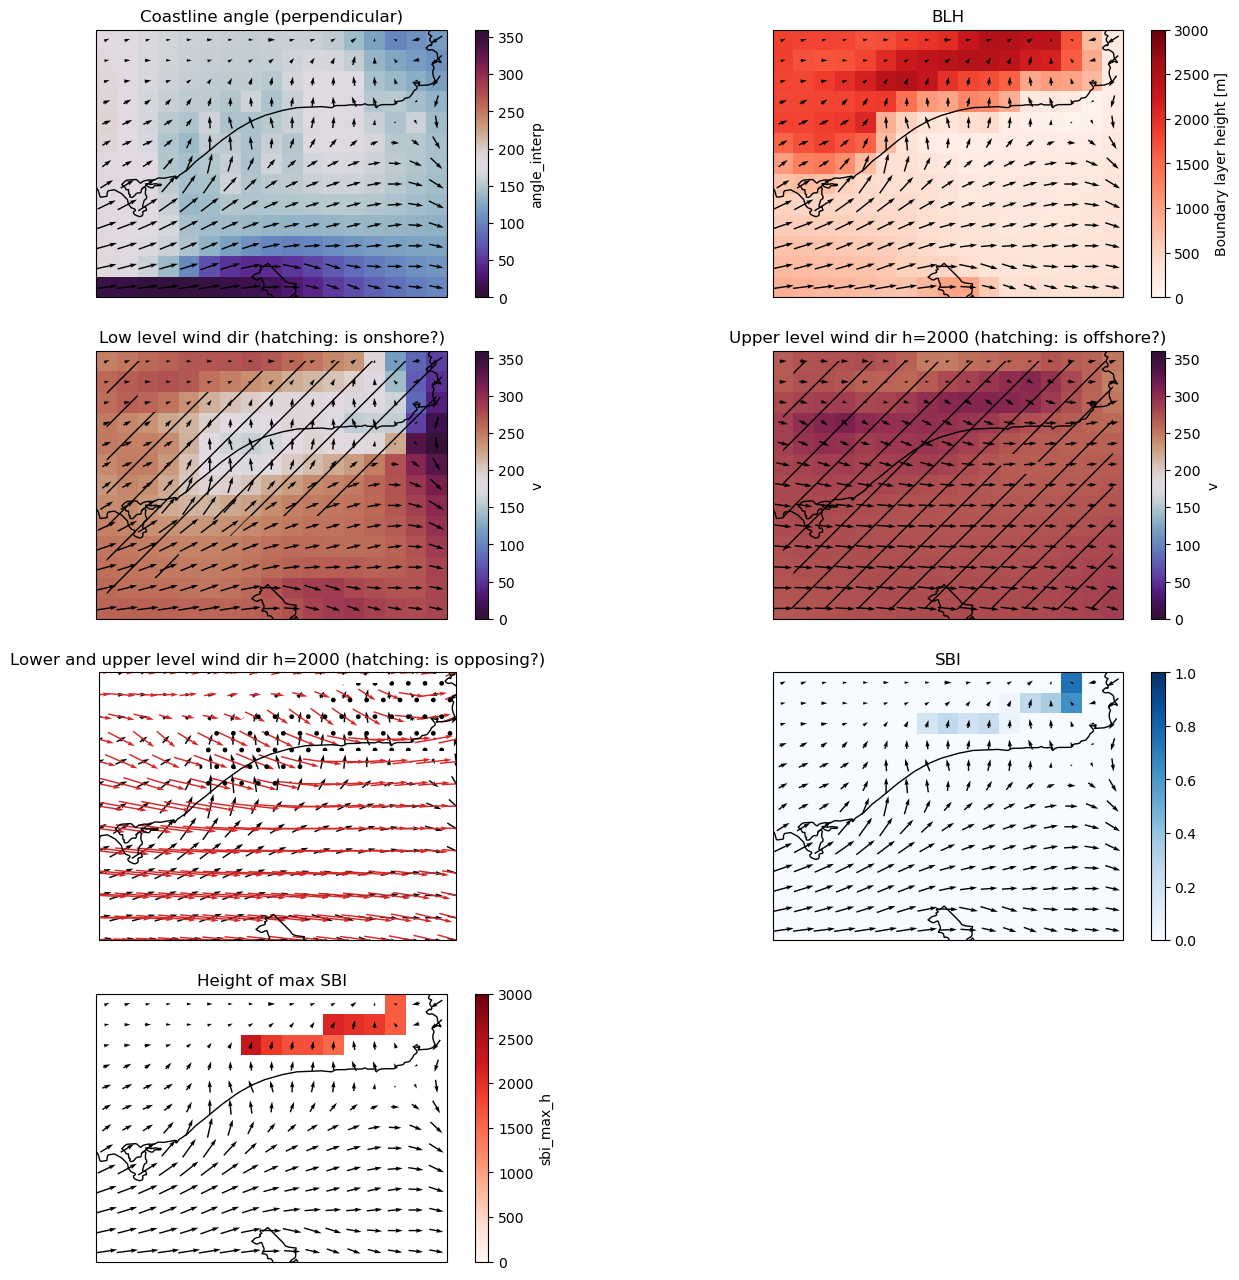

In [9]:
t=t3
plt.figure(figsize=[16,16])

coarsen=1

ax=plt.subplot(4,2,1,projection=ccrs.PlateCarree())
theta.plot(cmap="twilight_shifted",vmin=0,vmax=360)
wind_ds.sel(time=t,height=0).coarsen({"lat":coarsen,"lon":coarsen},boundary="pad").mean().plot.quiver(x="lon",y="lat",u="u",v="v")
ax.coastlines()
plt.title("Coastline angle (perpendicular)")

ax=plt.subplot(4,2,2,projection=ccrs.PlateCarree())
blh_da.sel(time=t).plot(cmap="Reds",vmin=0,vmax=3000)
wind_ds.sel(time=t,height=0).coarsen({"lat":coarsen,"lon":coarsen},boundary="pad").mean().plot.quiver(x="lon",y="lat",u="u",v="v")
ax.coastlines()
plt.title("BLH")

ax=plt.subplot(4,2,3,projection=ccrs.PlateCarree())
alpha.sel(time=t).plot(cmap="twilight_shifted",vmin=0,vmax=360)
wind_ds.sel(time=t,height=0).coarsen({"lat":coarsen,"lon":coarsen},boundary="pad").mean().plot.quiver(x="lon",y="lat",u="u",v="v")
xr.plot.contourf((sb_cond[0]).sel(time=t), levels=[0,0.5],colors="none",hatches=["","/"],add_colorbar=False)
ax.coastlines()
plt.title("Low level wind dir (hatching: is onshore?)")

ax=plt.subplot(4,2,4,projection=ccrs.PlateCarree())
h=2000
beta.sel(time=t,height=h).plot(cmap="twilight_shifted",vmin=0,vmax=360)
wind_ds.sel(time=t,height=h).coarsen({"lat":coarsen,"lon":coarsen},boundary="pad").mean().plot.quiver(x="lon",y="lat",u="u",v="v")
xr.plot.contourf((sb_cond[1]).sel(height=h,time=t), levels=[0,0.5],colors="none",hatches=["","/"],add_colorbar=False)
ax.coastlines()
plt.title("Upper level wind dir h="+str(h)+" (hatching: is offshore?)")

ax=plt.subplot(4,2,5,projection=ccrs.PlateCarree())
h=2000
wind_ds.sel(time=t,height=0).coarsen({"lat":coarsen,"lon":coarsen},boundary="pad").mean().plot.quiver(x="lon",y="lat",u="u",v="v",color="k",scale=100)
wind_ds.sel(time=t,height=h).coarsen({"lat":coarsen,"lon":coarsen},boundary="pad").mean().plot.quiver(x="lon",y="lat",u="u",v="v",color="tab:red",scale=100)
xr.plot.contourf((sb_cond[2]).sel(height=h,time=t), levels=[0,0.5],colors="none",hatches=["","."],add_colorbar=False)
ax.coastlines()
plt.title("Lower and upper level wind dir h="+str(h)+" (hatching: is opposing?)")

ax=plt.subplot(4,2,6,projection=ccrs.PlateCarree())
sbi.sel(time=t).plot(cmap="Blues",vmin=0,vmax=1)
wind_ds.sel(time=t,height=0).coarsen({"lat":coarsen,"lon":coarsen},boundary="pad").mean().plot.quiver(x="lon",y="lat",u="u",v="v")
ax.coastlines()
plt.title("SBI")

ax=plt.subplot(4,2,7,projection=ccrs.PlateCarree())
sbi_ds.sbi_max_h.sel(time=t).plot(cmap="Reds",vmin=0,vmax=3000)
wind_ds.sel(time=t,height=0).coarsen({"lat":coarsen,"lon":coarsen},boundary="pad").mean().plot.quiver(x="lon",y="lat",u="u",v="v")
ax.coastlines()
plt.title("Height of max SBI")